In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
import joblib
import matplotlib.pyplot as plt
import os

2025-07-14 13:46:34.842950: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-14 13:46:34.969883: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-14 13:46:34.998231: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-14 13:46:35.621896: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# === Загрузка и подготовка новых данных ===
file_path = 'dataset_bar_harmonics_median_cleaned.csv'
data = pd.read_csv(file_path)
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values('date')

# Агрегация по дате и интерполяция пропусков
data_daily = data.groupby(data['date'].dt.date)['value'].mean().reset_index()
data_daily.columns = ['date', 'value']
data_daily['date'] = pd.to_datetime(data_daily['date'])

full_date_range = pd.date_range(start=data_daily['date'].min(), end=data_daily['date'].max(), freq='D')
data_daily_full = pd.DataFrame({'date': full_date_range})
data_daily_full = data_daily_full.merge(data_daily, on='date', how='left')
data_daily_full['value'] = data_daily_full['value'].interpolate(method='linear')

values = data_daily_full['value'].values


In [3]:

# === Загрузка модели и скейлеров ===
history_length = 30  # Должен совпадать с обучающим
model = load_model('engine_param_forecast_attention.h5', compile=False)
scaler_X = joblib.load('scaler_X.save')
scaler_y = joblib.load('scaler_y.save')

2025-07-14 13:46:37.723308: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-07-14 13:46:37.723345: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: maybe-pc
2025-07-14 13:46:37.723349: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: maybe-pc
2025-07-14 13:46:37.723496: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 550.144.3
2025-07-14 13:46:37.723513: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 550.144.3
2025-07-14 13:46:37.723516: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 550.144.3
2025-07-14 13:46:37.723767: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions 

In [4]:


# === Прогноз на 3 дня вперёд ===
last_window = values[-history_length:]
predicted = []
for _ in range(15):
    input_seq = scaler_X.transform(last_window.reshape(-1, 1)).reshape(1, history_length, 1)
    pred = model.predict(input_seq)
    pred_inv = scaler_y.inverse_transform(pred)
    predicted.append(pred_inv[0, 0])
    last_window = np.append(last_window[1:], pred_inv[0, 0])

print('Прогнозы на 3 дня вперёд:', predicted)




1/1 [==============================] - 0s 16ms/step


2025-07-14 13:46:38.269242: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "108" frequency: 3302 num_cores: 8 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 12582912 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


1/1 [==============================] - 0s 15ms/step
Прогнозы на 3 дня вперёд: [1.5651964, 1.5452517, 1.5246148, 1.5051733, 1.4878205, 1.4701581, 1.4515338, 1.4401997, 1.4278063, 1.4242431, 1.4342262, 1.4384204, 1.4407741, 1.4413333, 1.427837]


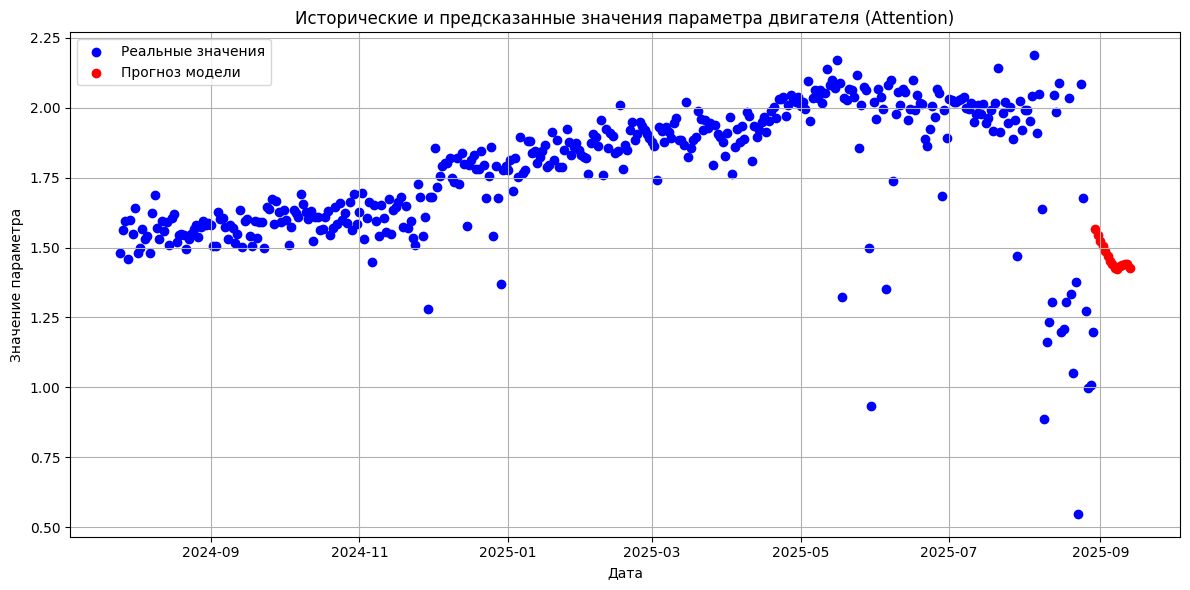

In [6]:
# === Визуализация ===
plot_days = 400  # Количество последних дней для отображения
plot_dates = data_daily_full['date'][-(plot_days):].reset_index(drop=True)
plot_values = data_daily_full['value'][-(plot_days):].reset_index(drop=True)

# Три следующих даты для прогноза
last_plot_date = plot_dates.iloc[-1]
next_dates = pd.date_range(start=last_plot_date + pd.Timedelta(days=1), periods=15, freq='D')
pred_x = pd.Series(next_dates)
pred_y = predicted

plt.figure(figsize=(12, 6))
plt.scatter(plot_dates, plot_values, color='blue', label='Реальные значения')
plt.scatter(pred_x, pred_y, color='red', label='Прогноз модели')
plt.xlabel('Дата')
plt.ylabel('Значение параметра')
plt.title('Исторические и предсказанные значения параметра двигателя (Attention)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()